# RunShell Input File Generator

In [70]:
%reload_ext autoreload
%autoreload 2


## create dir

In [79]:
import os
sim_name = 'gamma3'

cwd        = os.getcwd()
output_dir = os.path.join(cwd, 'NewSims', sim_name)
os.makedirs(output_dir, exist_ok=True)

# print(os.getcwd())
# print("Contents of", os.path.dirname(output_dir), "→", os.listdir(os.path.dirname(output_dir)))
# print("Contents of", output_dir, "→", os.listdir(output_dir))

## create all input files

In [80]:
from generate_inputs import *

# domain_params =  [2, 4, 0, 2*np.pi]
# create_input_files(
#     sim_name     = sim_name,
#     output_dir   = output_dir,
#     domain_type  = 'annulus',
#     domain_params = domain_params,
#     max_area     = 0.005,
#     tols = (0,0)
# )


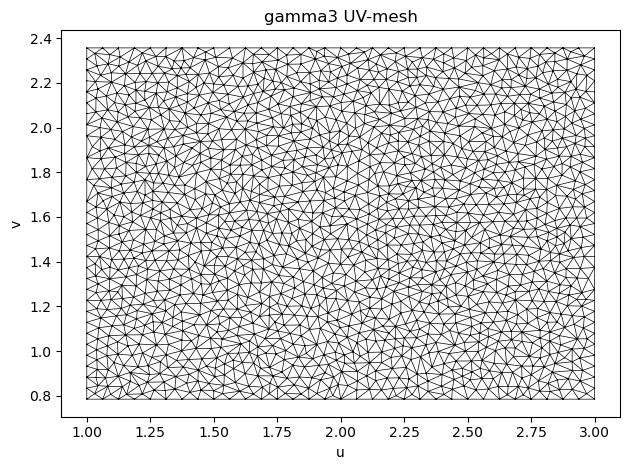

In [81]:
from generate_inputs import *

domain_params = [ 1, 3, np.pi/4, 3*np.pi/4 ]
create_input_files(
    sim_name     = sim_name,
    output_dir   = output_dir,
    domain_type  = 'rectangle',
    domain_params = domain_params,
    max_area   = 0.0015,
    tols = (0,0)
)


## Initial configuration

In [82]:

from generate_inputs import plot_uv_surface, func_to_matlab_str
x = lambda u,v: u#*np.cos(v) #np.sin(u)*np.cos(v)
y = lambda u,v: v #u*np.sin(v)
z = lambda u,v: 0.1*np.sin(u*v)
umin = domain_params[0]
umax = domain_params[1]
vmin = domain_params[2] 
vmax = domain_params[3]
# plot_uv_surface(x, y, z, uxmin, umax, vmin, vmax)

xpos = func_to_matlab_str(x)  
ypos = func_to_matlab_str(y)
zpos = func_to_matlab_str(z) 
print(xpos)
print(ypos)
print(zpos)


u
v
0.1*sin(u*v)


## GammaBar

In [83]:
import sympy as sp
from generate_inputs import calc_Gamma

u = sp.Symbol('u')
v = sp.Symbol('v')

#  example metric 
a = sp.Matrix([[1, 0], [0, u**2]])
Gamma_str = calc_Gamma(a, u, v)

print(Gamma_str)

[[['0', '0'], ['0', '-u']], [['0', '1./u'], ['1./u', '0']]]


## Params

In [ ]:
thickness = 0.001
YoungsModulus = 10000
PoisonRatio = 0.3
# "Lamme parameters" for connection energy
eta = 0.1
lambdaG = 5000
muG = 5000


## Generate RunShell input file

In [87]:
from generate_inputs import make_in_file
output_dir = os.path.join(cwd, 'NewSims', sim_name)
params = {
    'vertices_file': os.path.relpath(os.path.join(output_dir, f"{sim_name}_Vertices"), os.getcwd()),
    'faces_file':  os.path.relpath(os.path.join(output_dir, f"{sim_name}_Faces"), os.getcwd()),
    'loops':100000,
    'save_every':200,
    'abar':['1','0','0','1'],
    'bbar':['0','0','0','0'],
    'thickness':str(thickness),
    'E':str(YoungsModulus),
    'nu':str(PoisonRatio),
    'pos0':[xpos,ypos,zpos],
    'eta':str(eta),
    'lambdaG':str(lambdaG),
    'muG':str(muG),
    'gamma':Gamma_str,
    'thickness_adjust':'10',
    'metric_adjust':'0.5',
    'connection_adjust':'10',
    'restart':'0'
}
in_file = make_in_file(params, output_dir, sim_name)



# Run

In [86]:
in_file_path = os.path.relpath(in_file, os.getcwd())
!./RunShell < {in_file_path}


[DEBUG] thickness_formula = "0.001"
[DEBUG] Input eta = 0.1
NonEuclideanShell::NonEuclideanShell()   Number of Nodes = 1700
[DEBUG] isfixed value summary:
   -2 → 1700 vertices
NonEuclideanShell::NonEuclideanShell()   Number of Faces = 3274
	The initial bending energy is 5.84273316976248e-05
	The initial stretching energy is 0.0154150558447668
	The initial connection energy is 352.014495913678
0% Done: The current energy is 339.072033882241
 stretch = 0.0180894493141119 bend = 5.83956312296845e-05 conn = 339.053886037296
0% Done: The current energy is 261.387280970489
 stretch = 0.394437705578075 bend = 0.00637869689427287 conn = 260.986464568016
0% Done: The current energy is 226.647187701304
 stretch = 0.842966746710732 bend = 0.0195274631359176 conn = 225.784693491458
0% Done: The current energy is 203.944667194698
 stretch = 1.17847711156076 bend = 0.0272107269253983 conn = 202.738979356212
0% Done: The current energy is 184.865505587056
 stretch = 1.57425380702533 bend = 0.0357731

OSError: [Errno 5] Input/output error

# Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# Load vertices and faces (update file paths as needed)
vertices = np.loadtxt('vertices.dat')  # Nx3 (x, y, z)
faces = np.loadtxt('faces.dat', dtype=int)  # Mx3 (vertex indices)

# Load precomputed Gaussian curvature or bending energy per face (update file path)
# Assuming your scalar values (Gaussian curvature or Eb) are stored in a text file with one value per face:
face_scalar_data = np.loadtxt('face_scalar_data.dat')

# Compute per-vertex scalar data as an average of the adjacent faces
vertex_scalar_data = np.zeros(vertices.shape[0])
vertex_face_count = np.zeros(vertices.shape[0])

for i, face in enumerate(faces):
    for vertex in face:
        vertex_scalar_data[vertex] += face_scalar_data[i]
        vertex_face_count[vertex] += 1

vertex_scalar_data /= vertex_face_count

# Create triangulation
triangulation = Triangulation(vertices[:, 0], vertices[:, 1], triangles=faces)

# Plot 3D mesh
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with vertex scalar coloring
mesh = ax.plot_trisurf(
    triangulation, 
    vertices[:, 2],
    cmap='jet',
    shade=True,
    linewidth=0.1,
    edgecolor='none',
    antialiased=True,
    vmin=np.min(vertex_scalar_data),
    vmax=np.max(vertex_scalar_data)
)

mesh.set_array(vertex_scalar_data)
mesh.autoscale()

# Add colorbar to indicate scalar data
cbar = plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Gaussian Curvature or Bending Energy')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Colored by Gaussian Curvature or Bending Energy')

plt.tight_layout()
plt.show()


FileNotFoundError: vertices.dat not found.